In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

import torch
from torch import nn
from torch.nn.init import calculate_gain

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [2]:
from models import Davies2021, MLP_PINN, Base, LinearNeuralTangentKernel, SirenNet
from utils.helpers import gradient
class MyNet(Base):
    def __init__(
        self,
        lambda_siren=0.5,
        loss_lambda = (1.0, 10.0),
        dim_hidden_mlp=32, num_layers_mlp=8,
        dim_in=3, dim_hidden_siren=256, dim_out=1, num_layers_siren=3,
        activation=torch.nn.Softplus(30), last_activation=torch.nn.Softplus(30),
        linear_layer=nn.Linear,
        **kwarg
    ):
        super().__init__(**kwarg)
        self.lambda_siren = lambda_siren
        self.loss_lambda = loss_lambda
        self.MLP = Davies2021(dim_hidden_mlp, num_layers_mlp, dim_in, dim_out, activation, last_activation)
        #self.SIREN =  SirenNet(dim_in, dim_hidden_siren, dim_out, num_layers_siren)
        self.loss_function = nn.MSELoss(reduction='mean')
        self.one = nn.parameter.Parameter(torch.tensor(1.0), requires_grad=True)

    def forward(self, x):
        #y_mlp = (1 - self.lambda_siren) * self.MLP(x)
        #y_siren = self.lambda_siren * self.SIREN(x).squeeze()
        return self.MLP(x)
        #return self.SIREN(x).squeeze()

    def loss_residual(self, p):
        norm_p = torch.linalg.norm(p, dim=1)
        self._loss_residual = torch.mean((norm_p - 1)**2)
        return self._loss_residual

    def loss_max_residual(self, p):
        norm_p = torch.linalg.norm(p, dim=1)
        return torch.mean(torch.nn.ReLU(norm_p - 1))

    def loss_grad(self, p, grad):
        norm_p = torch.linalg.norm(p, dim=1)
        norm_g = torch.linalg.norm(grad, dim=1)
        self._loss_grad = torch.mean(-torch.einsum('ij,ij->i', p, grad)/norm_p/norm_g)
        #self._loss_grad = self.loss_function(p, grad)
        return self._loss_grad

    def loss_SDF(self, y, sdf):
        self._loss_SDF = self.loss_function(y, sdf)
        return self._loss_SDF

    def loss(self, x, sdf, grad, residual_x=None):
        y = self.forward(x)
        p = gradient(y, x)
        
        if residual_x is not None:
            residual_y = self.forward(residual_x)
            residual_p = gradient(residual_y, residual_x)

        self._loss = \
            self.loss_SDF(y, sdf) + \
            self.loss_grad(p, grad) + \
            0.1 * self.loss_max_residual(residual_p if residual_x is not None else p) + \
            0.1 * self.loss_residual(residual_p if residual_x is not None else p)
        return self._loss
#net = Davies2021(N_layers=3, width=256, activation=nn.ReLU()).to(device)
net = MyNet(
    num_layers_mlp=8, dim_hidden_mlp=32,
    num_layers_siren=3, dim_hidden_siren=256,
    loss_lambda=[1.0, 1.0], lambda_siren=0,
    activation=nn.Softplus(30)).to(device)

In [3]:
from functools import lru_cache

@torch.no_grad()
def bounding_box(x):
    _min = torch.min(x, dim=0)
    _max = torch.max(x, dim=0)
    return (_min[0], _max[0])

def generate_grid_points(bounds=((-1,-1,-1), (1, 1, 1)), nx=1000, ny=1000, nz=1000, device='cpu'):
    (x0, y0, z0), (x1, y1, z1) = bounds

    X = torch.linspace(x0, x1, nx, device=device)
    Y = torch.linspace(y0, y1, ny, device=device)
    Z = torch.linspace(z0, z1, nz, device=device)

    P = torch.cartesian_prod(X, Y, Z)
    return P

@lru_cache
def residual_sum_pdf(net, x, epsilon=1e-4):
    ndim = round(x.shape[0] ** (1/3))
    _min, _max = bounding_box(x)
    dx = (_max - _min) / (ndim-1)
    prod_dx = torch.prod(dx)
    x.requires_grad_(True)
    if x.grad is not None:
        x.grad.zero_()
    y = net.forward(x)
    p = gradient(y, x, False)
    with torch.no_grad():
        norm_p = torch.linalg.norm(p, dim=1)
        residual = (norm_p - 1.0)**2
        pdf = torch.log(residual / epsilon)
        mark = pdf < 0
        pdf[mark] = 0
        return (pdf.sum() * prod_dx)

def residual_likelihood(net, x, sum_pdf=1.0, epsilon=1e-4):
    x.requires_grad_(True)
    if x.grad is not None:
        x.grad.zero_()
    y = net.forward(x)
    p = gradient(y, x, False)
    x.requires_grad_(False)
    with torch.no_grad():
        norm_p = torch.linalg.norm(p, dim=1)
        residual = (norm_p - 1.0)**2
        pdf = torch.log(residual / epsilon)
        mark = pdf < 0
        pdf[mark] = 0
        return pdf / sum_pdf

def random_points_from_residual(net, num_points=1000, grid_points=None):
    assert(grid_points is not None)
    assert(len(grid_points.shape) == 2)
    assert(grid_points.shape[1] == 3)

    device = grid_points.device
    with torch.no_grad():
        _min, _max = bounding_box(grid_points)
        _scale = _max - _min
        _num_randoms = round(num_points*2)
        x = torch.rand((_num_randoms,), device=device)*_scale[0] + _min[0]
        y = torch.rand((_num_randoms,), device=device)*_scale[1] + _min[1]
        z = torch.rand((_num_randoms,), device=device)*_scale[2] + _min[2]
        points = torch.vstack((x,y,z)).T

    sum_pdf = residual_sum_pdf(net, grid_points)
    likelihood = residual_likelihood(net, points, sum_pdf=sum_pdf)
    mask = torch.rand((_num_randoms,), device=device) > likelihood
    points = points[mask]
    return points[:num_points]


In [4]:
import os
from utils import RandomMeshSDFDataset, ImplicitDataset, batch_loader

# Train from random calculated sdf
dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
#train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', M=int(1e6), W=10, device=device)
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
print(train_dataset)

# filter out discontinous points
grads = train_dataset.grads
norm_grad = torch.linalg.norm(grads, dim=1)
mark = (norm_grad <= 1.0)
train_dataset.grads = grads[mark]
train_dataset.points = train_dataset.points[mark]
train_dataset.sdfs = train_dataset.sdfs[mark]
grid_points = train_dataset.points

print(f'Filtered points: {len(train_dataset.points)}')

from utils.optimizer import CallbackScheduler

# Optimization
torch.nn.utils.clip_grad_norm_(net.parameters(), 10.0)
optimizer=torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.5),
    CallbackScheduler.reduce_lr(0.2),
    # CallbackScheduler.init_LBFGS(
    #     lr=1, max_iter=40, max_eval=60, 
    #     tolerance_grad=1e-5, tolerance_change=1e-9,
    #     history_size=100,
    #     line_search_fn=None
    # ),
    CallbackScheduler.nothing(),
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

ImplicitDataset (19683 points)
Filtered points: 17423


In [10]:
expand_size = 0.5
_min, _max = bounding_box(grid_points)
_min = _min - expand_size
_max = _max + expand_size
grid_points = generate_grid_points(bounds=(_min.cpu().detach().tolist(), _max.cpu().detach().tolist()), nx=50, ny=50, nz=50, device=device)
print(_min, _max)

tensor([-2.1657, -2.1657, -2.1657], device='cuda:0') tensor([2.1657, 2.1657, 2.1657], device='cuda:0')


In [16]:
expand_size = 0.05
_min, _max = bounding_box(train_dataset.points)
_min = _min - expand_size
_max = _max + expand_size
grid_points = generate_grid_points(bounds=(_min.cpu().detach().tolist(), _max.cpu().detach().tolist()), nx=50, ny=50, nz=50, device=device)
print(_min, _max)

tensor([-0.7157, -0.7157, -0.7157], device='cuda:0') tensor([0.7157, 0.7157, 0.7157], device='cuda:0')


In [28]:
from torch.utils.data import DataLoader
from math import ceil

batch_size = len(train_dataset.points)
lr_step = 150

LR_CALLBACK_EVERY_EPOCH = int(lr_step * ceil(len(train_dataset.points) / batch_size))
MAX_EPOCHS = int(LR_CALLBACK_EVERY_EPOCH * len(lr_scheduler))
PRINT_EVERY_EPOCH = int(MAX_EPOCHS // 10)


#points = train_dataset.points
#sdfs = train_dataset.sdfs
#grads = train_dataset.grads
#points.requires_grad_(True)
print(f'Max epoch: {MAX_EPOCHS} (PRINT: {PRINT_EVERY_EPOCH}, CALLBACK: {LR_CALLBACK_EVERY_EPOCH})')

is_PINN = True
print(f'LR = {lr_scheduler.lr}')
try:
    epoch = 0
    while epoch < MAX_EPOCHS:
        for points, sdfs, grads in batch_loader(train_dataset.points, train_dataset.sdfs, train_dataset.grads, batch_size=batch_size):
            
            # Training
            lr_scheduler.optimizer.zero_grad()
            
            if is_PINN:
                points.requires_grad_(True)
                if 'residual_points' in locals():
                    residual_points.requires_grad_(True)
                    loss = net.loss(points, sdfs, grads, residual_points)
                else:
                    loss = net.loss(points, sdfs, grads, points)
            else:
                loss = net.loss_SDF(points, sdfs)
            loss.backward()
            lr_scheduler.optimizer.step(lambda: loss)

            lr_scheduler.step_when((epoch % LR_CALLBACK_EVERY_EPOCH) == LR_CALLBACK_EVERY_EPOCH - 1, verbose=False)
            if epoch % PRINT_EVERY_EPOCH == 0:
                print(f'#{epoch} Loss: {net._loss_SDF:.6f} {net._loss_residual:.6f} {net._loss_grad:.6f}')

            epoch += 1
        
    print(f'#{epoch} Loss: {net._loss_SDF:.6f} {net._loss_residual:.6f} {net._loss_grad:.6f}\nSuccess')
except KeyboardInterrupt as e:
    print('Bye bye')



Max epoch: 450 (PRINT: 45, CALLBACK: 150)
LR = 0.0005
#0 Loss: 0.000071 0.031970 -0.990054
#45 Loss: 0.000070 0.032007 -0.990170
#90 Loss: 0.000070 0.031974 -0.990203
#135 Loss: 0.000070 0.031959 -0.990238
#180 Loss: 0.000070 0.031945 -0.990271
#225 Loss: 0.000069 0.031930 -0.990308
#270 Loss: 0.000069 0.031958 -0.990345
#315 Loss: 0.000069 0.031871 -0.990379
#360 Loss: 0.000069 0.031875 -0.990418
#405 Loss: 0.000069 0.031883 -0.990455
#450 Loss: 0.000069 0.031791 -0.990489
Success


In [27]:
lr_scheduler.set_lr(0.0005)
print(lr_scheduler.lr)

0.0005


In [65]:
lr_scheduler.LBFGS(
    lr=1, max_iter=40, max_eval=60, 
    tolerance_grad=1e-5, tolerance_change=1e-9,
    history_size=100,
    line_search_fn=None
)

In [75]:
lr_scheduler.ADAM(lr=0.01, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)

In [25]:
_residual_points = random_points_from_residual(net, num_points=20000, grid_points=grid_points)
with torch.no_grad():
    if 'residual_points' in locals():
        residual_points = torch.cat((residual_points, _residual_points), 0)
    else:
        residual_points = torch.cat((train_dataset.points, _residual_points), 0)
    train_dataset.points.requires_grad_(False)
print(residual_points.shape)

torch.Size([127423, 3])


In [52]:
del residual_points

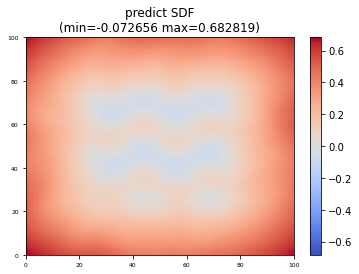

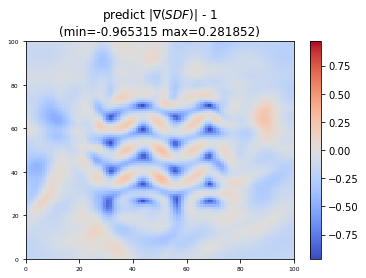

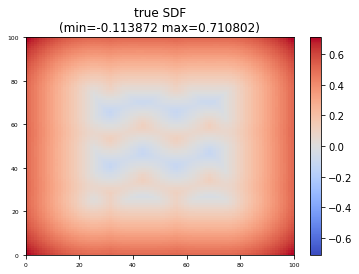

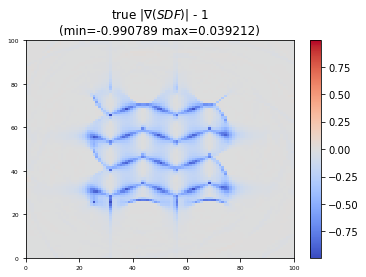

In [29]:
from utils import SDFVisualize
net.to(device)
visualize = SDFVisualize(z_level=0.0, step=0.05, offset=30, nums=100, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)

In [ ]:
from utils.dataset import TestDataset
test_dataset = TestDataset(dataset_name+'_test.npz', device=device)
print('Uniform SDFS: ', net.test(test_dataset.uniform.points, test_dataset.uniform.sdfs).cpu().detach().numpy())
print('Random SDFS:', net.test(test_dataset.random.points, test_dataset.random.sdfs).cpu().detach().numpy())
print('Outside SDFS:', net.test(test_dataset.outside.points, test_dataset.outside.sdfs).cpu().detach().numpy())
print('Train residual: ', net.test_residual(train_dataset.points).cpu().detach().numpy())
print('Uniform gradient: ', net.test_gradient(test_dataset.uniform.points, test_dataset.uniform.gradients).cpu().detach().numpy())
print('Uniform residual: ', net.test_residual(test_dataset.uniform.points).cpu().detach().numpy(), net.test_residual(test_dataset.random.points).cpu().detach().numpy())
print('Actual Uniform residual: ', torch.mean((test_dataset.uniform.gradients - 1)**2).cpu().detach().numpy())